In [164]:
import pmm 

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

def real_u(x):
    return  (1/ (2* np.pi**2))*((np.sin(np.pi * x))**2)

def gauss_kernel(x1, x2, L=0.25):
    return np.exp(- (x1-x2)**2 / (2* L**2))

def gauss_kernel_derix(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (-(x1 - x2) / L**2)

def gauss_kernel_deriy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * ((x1 - x2) / L**2)

def gauss_kernel_derixy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * (-(x1-x2)**2  + L**2)

def gauss_kernel_derixx(x1, x2, L=0.25): #This is A operator 
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  - L**2)

def gauss_kernel_deriyy(x1, x2, L=0.25): #This is A_hat operator 
    return gauss_kernel_derixx(x1, x2, L) 

#AA_hat operator
def gauss_kernel_derixxyy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**8) *(3* (L**4) - 6* (L**2)*((x1-x2)**2) + (x1-x2)**4)

g1 =  lambda x: np.cos(2*np.pi*x)
b1 = lambda x: 0

d1, d2 = 0, 1
D = [0, 1]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


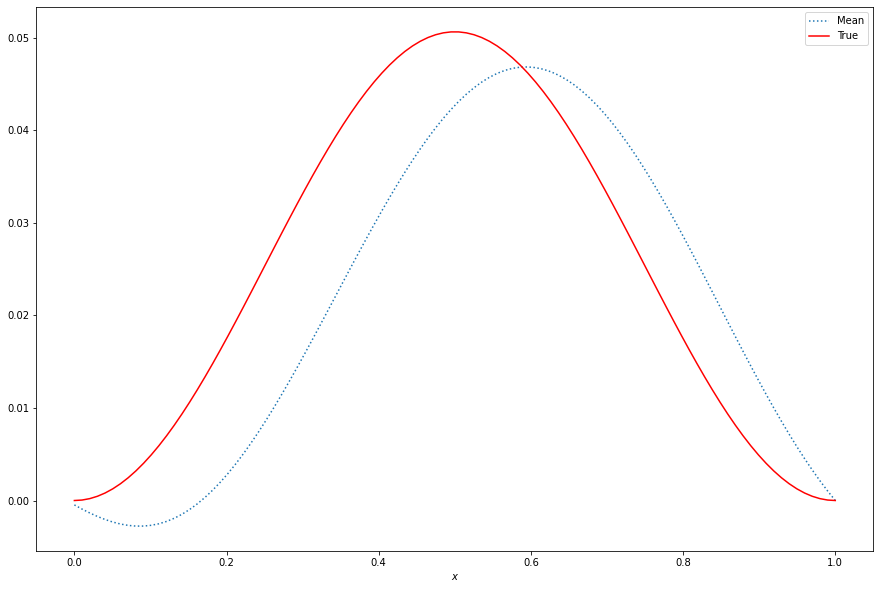

In [121]:
poisson = pmm.PMM(g1, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)

N = 100
X = [(1/N)*i for i in range(N)]
mean1, var1 = poisson.posterior(X, 10, 2)
plt.figure(figsize = (15,10))
# compare the mean of multivariate normal with true solution 
plt.plot(np.linspace(0, 1, N),  mean1, linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.xlabel(r'$x$')
plt.legend(['Mean','True'])
plt.savefig('1.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


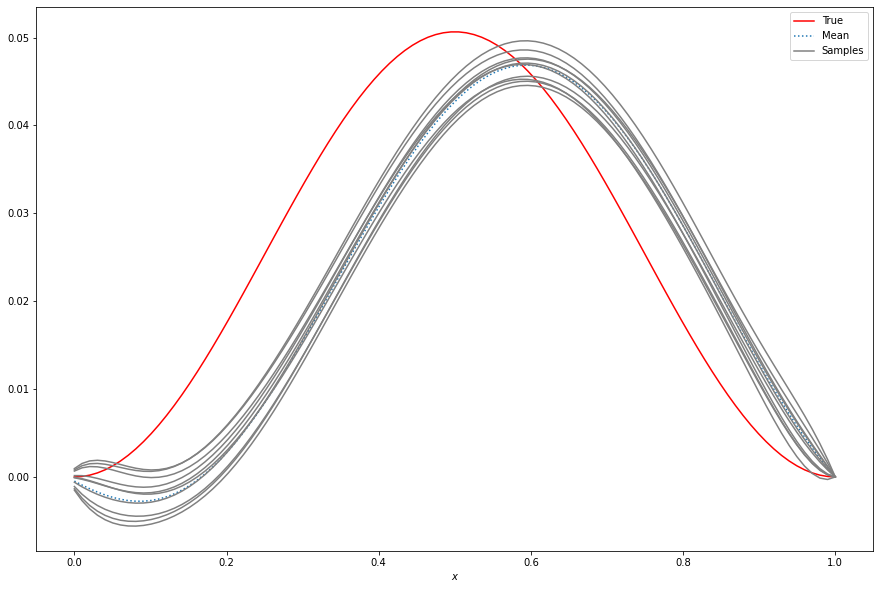

In [122]:
sample = np.random.multivariate_normal(mean1, var1, size=10)
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.plot(np.linspace(0, 1, N),  mean1, linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.xlabel(r'$x$')
plt.legend(['True', 'Mean', 'Samples'])
plt.savefig('2.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


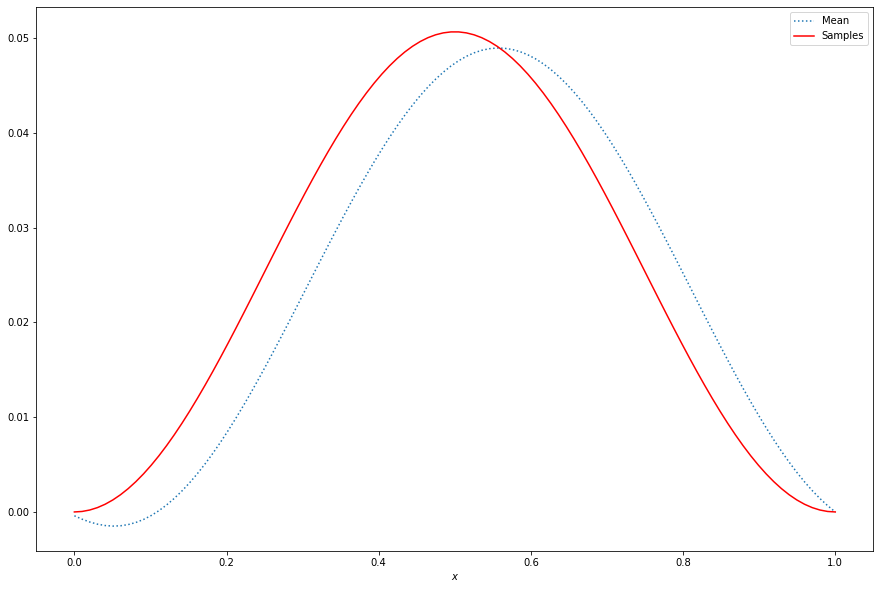

In [123]:
mean2, var2 = poisson.posterior(X, 16, 2)
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0, 1,  N),  mean2,  linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.xlabel(r'$x$')
plt.legend(['Mean', 'Samples'])
plt.savefig('3.eps', format='eps')

<ipython-input-124-f23a8a8a3e3a>:1: RuntimeWarning: covariance is not positive-semidefinite.
  sample = np.random.multivariate_normal(mean2, var2, size=10)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


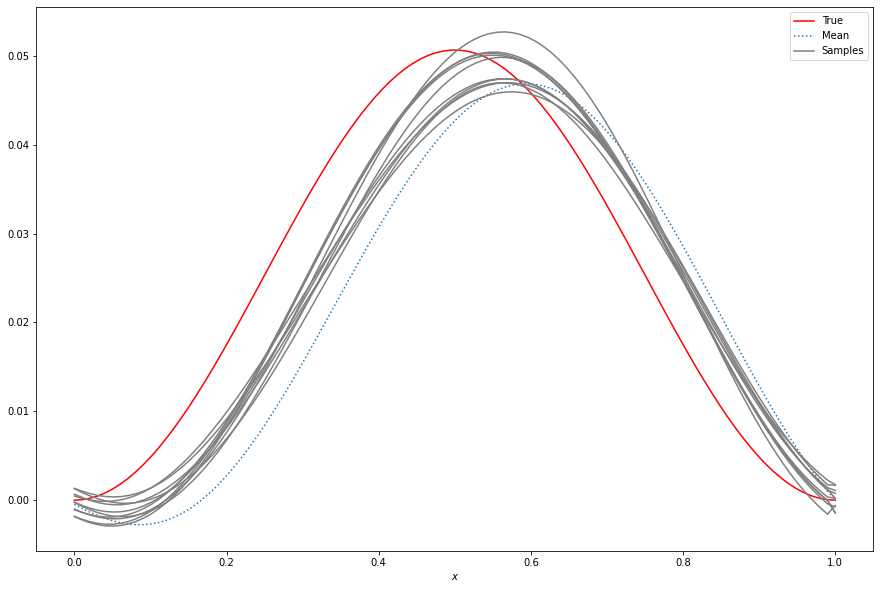

In [124]:
sample = np.random.multivariate_normal(mean2, var2, size=10)
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.plot(np.linspace(0, 1, N),  mean1, linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.xlabel(r'$x$')
plt.legend(['True', 'Mean', 'Samples'])
plt.savefig('4.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


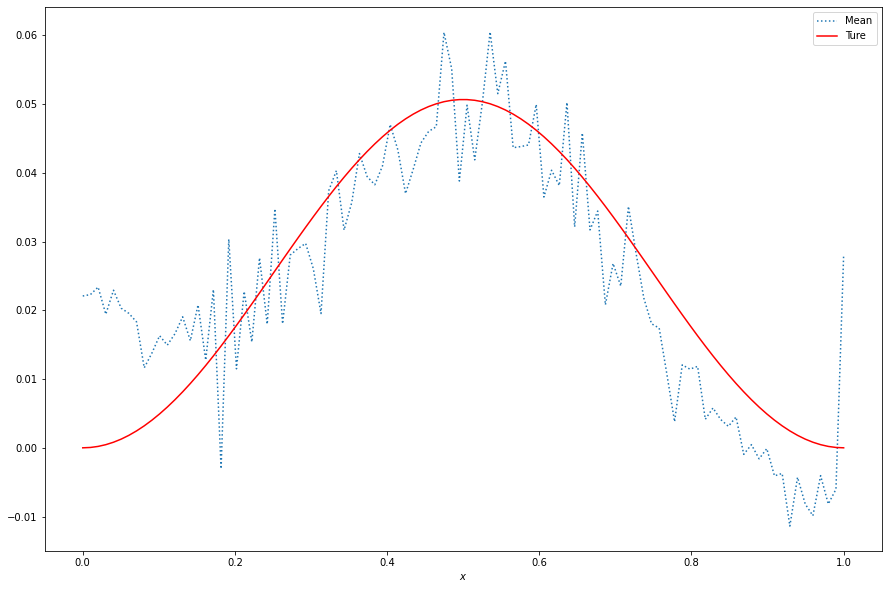

In [125]:
mean3, var3 = poisson.posterior(X, 25, 2)
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0, 1,  N),  mean3,  linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.xlabel(r'$x$')
plt.legend(['Mean', 'Ture'])
plt.savefig('overfitting.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


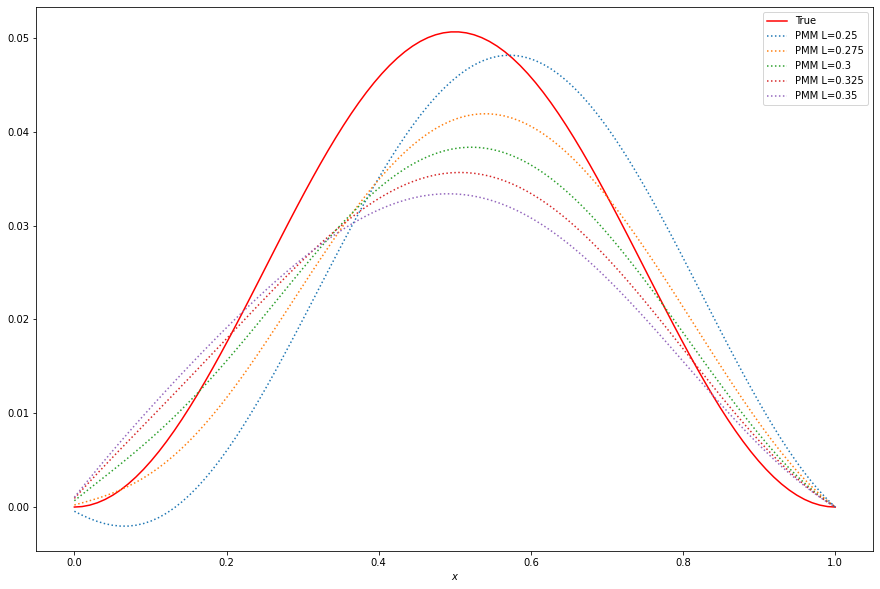

In [139]:
# PMM with Gaussian kernel and different selection of L

from cProfile import label


L = [0.25+ 0.025*i for i in range(0, 5)]

N = 100
X = [(1/N)*i for i in range(N)]
plt.figure(figsize = (15,10))
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r', label='True')
for l in L:

    def gauss_kernel(x1, x2, L=l):
        return np.exp(- (x1-x2)**2 / (2* L**2))

    def gauss_kernel_derix(x1, x2, L=l):
        return np.exp(-(x1-x2)**2 / (2* L**2)) * (-(x1 - x2) / L**2)

    def gauss_kernel_deriy(x1, x2, L=l):
        return np.exp(-(x1-x2)**2 / (2* L**2)) * ((x1 - x2) / L**2)

    def gauss_kernel_derixy(x1, x2, L=l):
        return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * (-(x1-x2)**2  + L**2)

    def gauss_kernel_derixx(x1, x2, L=l): #This is A operator 
        return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  - L**2)

    def gauss_kernel_deriyy(x1, x2, L=l): #This is A_hat operator 
        return gauss_kernel_derixx(x1, x2, L) 

    new_poisson = pmm.PMM(g1, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)
    new_mean1, new_var1 = new_poisson.posterior(X, 13, 2)
    plt.plot(np.linspace(0, 1, N),  new_mean1, linestyle = 'dotted', label=f'PMM L={l}')

plt.xlabel(r'$x$')
plt.legend(loc = 'upper right')

plt.savefig('PMM_Gauss_choiceL.eps', format='eps')


In [172]:
### PMM with Matern kernel 
def matern_kernel(x1, x2, sigma=0.01, l = 0.25):
    r = x1 - x2
    return sigma**2 * (1 + r*np.sqrt(5)/l + 5 * r**2 / (3*l**2)) * np.exp(- r*np.sqrt(5) / l)

def matern_kernel_derix(x1, x2, sigma=0.01, l = 0.25):
    r = x1 - x2
    return - (5*sigma**2 * r *np.exp(- r*np.sqrt(5)/l)*(l + np.sqrt(5)*r)) / (3* l**3)

def matern_kernel_deriy(x1, x2, sigma=0.01, l=0.25):
    r = x1 - x2
    return (5*sigma**2 * r *np.exp(- r*np.sqrt(5)/l)*(l + np.sqrt(5)*r)) / (3* l**3)

def matern_kernel_derixx(x1, x2, sigma=0.01, l=0.25):
    r = x1 - x2
    return - (5* sigma**2 * np.exp(- r*np.sqrt(5)/l) * (l**2 + np.sqrt(5)*l*r - 5*r**2)) / (3* l**4)

def matern_kernel_deriyy(x1, x2, sigma=0.01, l=0.25):
    r = x1 - x2 
    return - (5* sigma**2 * np.exp(- r*np.sqrt(5)/l) * (l**2 + np.sqrt(5)*l*r - 5*r**2)) / (3* l**4)

def matern_kernel_derixxyy(x1, x2, sigma=0.01, l=0.25):
    r = x1 - x2
    return 25 * sigma**2 * np.exp(- r*np.sqrt(5)/l) * (3* l**2 - 5*np.sqrt(5) * r + 5* r**2) / (3* l**6)


Forward PMM with Polynomial Kernel 

ValueError: x and y must have same first dimension, but have shapes (80,) and (96,)

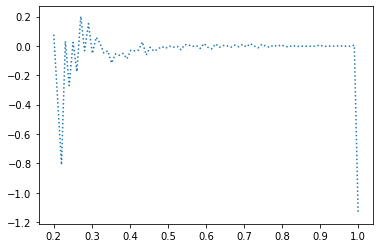

In [188]:

poisson_metern = pmm.PMM(g1, b1, matern_kernel_derixx, matern_kernel, matern_kernel_deriyy, matern_kernel, 0, 1, D, matern_kernel, matern_kernel_derixxyy, matern_kernel_derixx, matern_kernel_deriyy, matern_kernel)

N = 100 
X = [(1/N)*i for i in range(N)]
mean_metern, var_metern = poisson_metern.posterior(X, 14, 2)

# compare the mean of multivariate normal with true solution 
plt.plot(np.linspace(0.2, 1, 80),  mean_metern[20:], linestyle = 'dotted')
plt.plot(np.linspace(0.2, 1, 80), real_u(np.linspace(0, 1, 100))[4:], color = 'r')
plt.xlabel(r'$x$')
plt.legend(['Mean','True'])
plt.show()


In [ ]:
'''
sample = np.random.multivariate_normal(mean1, var1, size=10)
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.plot(np.linspace(0, 1, N),  mean1, linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.xlabel(r'$x$')
plt.legend(['True', 'Mean', 'Samples'])
plt.savefig('6.eps', format='eps')
'''

In [ ]:
'''
mean2, var2 = poisson.posterior(X, 16, 2)

plt.plot(np.linspace(0, 1,  N),  mean2,  linestyle = 'dotted')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.xlabel(r'$x$')
plt.legend(['Mean', 'Samples'])
plt.savefig('3.eps', format='eps')
'''

### Baysian Inverse Problem 

In [7]:
sample_x = np.linspace(0, 1, 100)
sample_y = sample_x + np.random.normal(0, 0.01**2, 100)

In [8]:
new_var2 = var2 + (0.001**2)*np.identity(100)

In [9]:
theta = np.linspace(-1, 3, 40)

N = 2
X = [(1/N)*i for i in range(N)]
prob = []

for i in range(40):
    g2 =  lambda x: np.cos(2*np.pi*x) / theta[i] 
    poisson_tmp = pmm.PMM(g2, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)

    mean, var = poisson_tmp.posterior(X, 10, 2)
    modified_var = get_near_psd(var)
    new_var = modified_var + (0.001**2)*np.identity(100)
    distribution = multivariate_normal(mean, new_var)
    prob.append(distribution.pdf(sample_y))

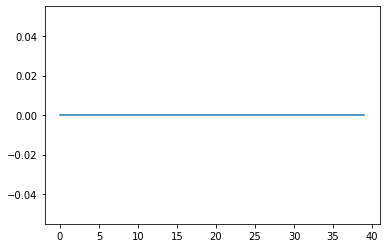

In [10]:
plt.plot(prob)

In [12]:
theta[20]

1.051282051282051

In [41]:
g2 =  lambda x: np.cos(2*np.pi*x) / theta[20] 


N = 2
X = [(1/N)*i for i in range(N)]

poisson_tmp = pmm.PMM(g2, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)
mean, var = poisson_tmp.posterior(X, 16, 2)

In [42]:
var

array([[ 9.08661080e-07, -7.54452623e-07],
       [-1.06006088e-05,  4.53548705e-06]])

In [ ]:
new_var

In [34]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [43]:
distribution = multivariate_normal(mean, var + 0.001**2*np.identity(N))

ValueError: the input matrix must be positive semidefinite

In [ ]:

prob.append(distribution.pdf(sample_y))